In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from collections import defaultdict
from scipy.stats.stats import pearsonr
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
df = pd.read_csv('training.csv')

In [3]:
df['MMRAcquisitionAuctionAveragePrice'].fillna(df['MMRAcquisitionAuctionAveragePrice'].median(), inplace = True)
df['MMRAcquisitionAuctionCleanPrice'].fillna(df['MMRAcquisitionAuctionCleanPrice'].median(), inplace = True)
df['MMRAcquisitionRetailAveragePrice'].fillna(df['MMRAcquisitionRetailAveragePrice'].median(), inplace = True)
df['MMRAcquisitonRetailCleanPrice'].fillna(df['MMRAcquisitonRetailCleanPrice'].median(), inplace = True)
df['MMRCurrentAuctionAveragePrice'].fillna(df['MMRCurrentAuctionAveragePrice'].median(), inplace = True)
df['MMRCurrentAuctionCleanPrice'].fillna(df['MMRCurrentAuctionCleanPrice'].median(), inplace = True)
df['MMRCurrentRetailAveragePrice'].fillna(df['MMRCurrentRetailAveragePrice'].median(), inplace = True)
df['MMRCurrentRetailCleanPrice'].fillna(df['MMRCurrentRetailCleanPrice'].median(), inplace = True)

In [4]:
df['MMR_factor'] = ( df['MMRAcquisitionAuctionAveragePrice'] + df['MMRAcquisitonRetailCleanPrice'] + df['MMRCurrentAuctionCleanPrice'] + df['MMRCurrentRetailAveragePrice']) / 4

In [5]:
df.isnull().sum() # Check if there are some numerical attributes with missing values

RefId                                    0
IsBadBuy                                 0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  1911
SubModel                                 7
Color                                    7
Transmission                             8
WheelTypeID                           2573
WheelType                             2577
VehOdo                                   0
Nationality                              4
Size                                     4
TopThreeAmericanName                     4
MMRAcquisitionAuctionAveragePrice        0
MMRAcquisitionAuctionCleanPrice          0
MMRAcquisitionRetailAveragePrice         0
MMRAcquisitonRetailCleanPrice            0
MMRCurrentAuctionAveragePrice            0
MMRCurrentA

In [6]:
df_new = df[['VehicleAge','VehOdo','MMR_factor','VehBCost','WarrantyCost']] #Create new dataframe the variables that we'll use in the clustering

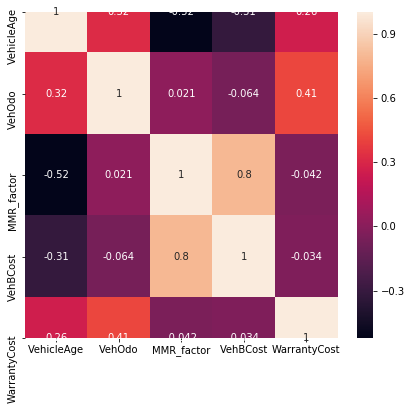

In [7]:
# check the correlation because we don't want clusters with two attributes highly correlated
corr = df_new.corr()
plt.subplots(figsize =(7, 6))
hm = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [8]:
Q1 =  df_new.quantile(0.25)
Q3 = df_new.quantile(0.75)
IQR = Q3 - Q1

In [9]:
df_in = df_new[~((df_new < (Q1 - 1.5 * IQR)) |(df_new > (Q3 + 1.5 * IQR))).any(axis=1)]

df_in.shape

(56150, 5)

In [10]:
df_in.isnull().sum() 

VehicleAge      0
VehOdo          0
MMR_factor      0
VehBCost        0
WarrantyCost    0
dtype: int64

In [17]:
df1 = df_new[['WarrantyCost','VehicleAge','VehBCost']]

In [18]:
X = MinMaxScaler().fit_transform(df1.values)

In [19]:
kmeans = KMeans(n_clusters = 8, n_init = 7, max_iter = 150)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=150,
       n_clusters=8, n_init=7, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [20]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([10157,  9210,  4995, 10398,  7189,   476,  7118,  8843],
       dtype=int64))

In [21]:
hist, bins = np.histogram(kmeans.labels_, 
                          bins=range(0, len(set(kmeans.labels_)) + 1))
dict(zip(bins, hist))

{0: 10157, 1: 9210, 2: 4995, 3: 10398, 4: 7189, 5: 476, 6: 7118, 7: 8843}

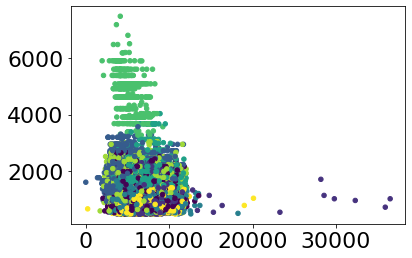

In [23]:
plt.scatter(df_new['VehBCost'], df_new['WarrantyCost'], 
            c=kmeans.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [24]:
centers = kmeans.cluster_centers_

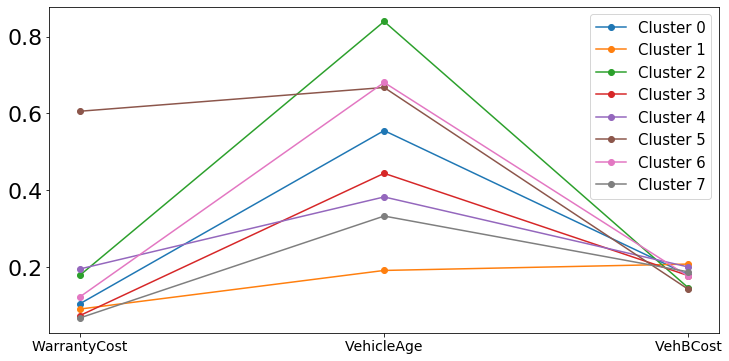

In [25]:
plt.figure(figsize=(12, 6))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(0, len(df1.columns)), df1.columns, fontsize=14)
plt.legend(fontsize=15)
plt.show()

In [28]:
# MMR_factor-warrantycost: sse 145 sil 0.35
# MMR_factor-vehicleage: sse 235 sil 0.485  
# vehbcost-vehicleage: sse 107 sil 0.60 BEST VALUES 2 ----- without outliers(fillna=median) sse 667 sil: 0.40 WHY?????
# vehbcost-vehicleage-warranty: sse 407 sil 0.36 BEST VALUES 3 
# vehbcost-vehicleage-vehodo: sse 637 sil 0.32
# vehbcost-vehicleage-vehodo: sse 1770 sil 0.39 ----- 2 clusters
print('SSE %s' % kmeans.inertia_)  #sse 93 sil 0.35 with warranty and vehbcost with outliers: sse 799 sli 0.33
print('Silhouette %s' % silhouette_score(X, kmeans.labels_)) #sse 345 sil 0,26 adding vehodo

SSE 410.48692435531376
Silhouette 0.33087267922328956


In [31]:
sse_list = list()
max_k = 20
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=7, max_iter=100)
    kmeans.fit(X)
    
    sse = kmeans.inertia_
    sse_list.append(sse)

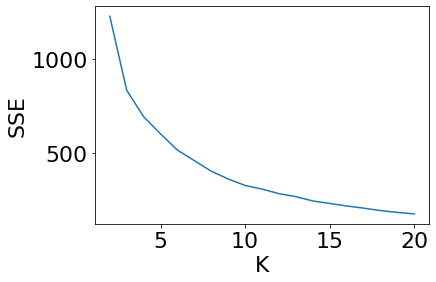

In [32]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [29]:
#DBSCAN

In [34]:
df_new.head()

,VehicleAge,VehOdo,MMR_factor,VehBCost,WarrantyCost
0,2,61184,8685.25,6100.0,533
1,3,92383,6459.25,4000.0,1630
2,2,45965,9635.50,7500.0,693
3,4,80169,6217.00,4725.0,1633
4,4,77372,6551.25,5670.0,1623


In [35]:
df2 = df_new[['VehOdo','WarrantyCost','VehBCost']]

In [36]:
Y = StandardScaler().fit_transform(df2.values)

In [58]:
dbscan = DBSCAN(eps = 0.8, min_samples = 9)
dbscan.fit(Y)
print('Silhouette %s' % silhouette_score(Y, dbscan.labels_))

Silhouette 0.7422665371338836


In [59]:
np.unique(dbscan.labels_,return_counts = True)

(array([-1,  0], dtype=int64), array([   33, 58353], dtype=int64))

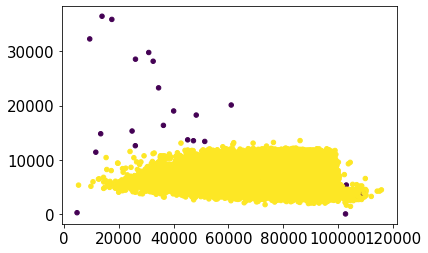

In [60]:
plt.scatter(df2['VehOdo'], df2['VehBCost'], c=dbscan.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [51]:
print('Silhouette %s' % silhouette_score(Y, dbscan.labels_,sample_size=20000))
#Vehbcost-vehodo: 0.30 eps:0.3 sample: 10000 sample: 50 ---> 0.49
#vehodo-warranty: 0.44 eps:0.3 sample: 10000
#vehodo-warranty: 0.61 eps: 0.3 sapmle: 100
#vehodo-warranty: 0.64 eps: 0.3 sample: 50 ---- eps:0.5 sse 0.63
#vehodo-mmr: 0.37 eps:0.3 sample:50
#vehodo-warranty-vehbcost: 0.41 eps: 0.3 sample 50
#vehodo-warranty-mmr_factor: 0.18 eps: 0.3 sample 50
#vehodo-warranty-vehbcost: 0.52 eps: 0.7 sample 50
#vehodo-warranty-vehbcost: 0.59 eps: 0.8 sample 50
#vehodo-warranty-vehbcost: 0.59 eps: 0.9 sample 50
#vehodo-warranty-vehbcost: 0.64 eps: 0.8 sample 150  BEST VALUE
#vehodo-warranty-vehbcost: 0.63 eps: 0.8 sample 140
#vehodo-warranty-vehbcost: 0.63 eps: 0.8 sample 160
#vehodo-warranty-vehbcost: 0.62 eps: 0.8 sample 150 
#vehodo-warranty-vehbcost: 0.60 eps: 0.6 sample 150 

Silhouette 0.6260303714852143


In [30]:
from scipy.spatial.distance import pdist, squareform

In [31]:
K = StandardScaler().fit_transform(df2.sample(n=10000))

C:\Users\bonin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\bonin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [32]:
dist = pdist(K, 'euclidean') 
print (dist)
dist = squareform(dist) 
print()
print(dist)

[1.92704315 1.94017766 1.08047877 ... 2.83745292 2.40700076 2.03700678]

[[0.         1.92704315 1.94017766 ... 2.21725886 1.42023999 1.37711462]
 [1.92704315 0.         1.08944106 ... 3.53176175 2.68392448 1.28914738]
 [1.94017766 1.08944106 0.         ... 3.41866548 2.09821909 1.08348831]
 ...
 [2.21725886 3.53176175 3.41866548 ... 0.         2.83745292 2.40700076]
 [1.42023999 2.68392448 2.09821909 ... 2.83745292 0.         2.03700678]
 [1.37711462 1.28914738 1.08348831 ... 2.40700076 2.03700678 0.        ]]


In [ ]:
k = 20
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

In [ ]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [46]:
#HIERARCHICAL

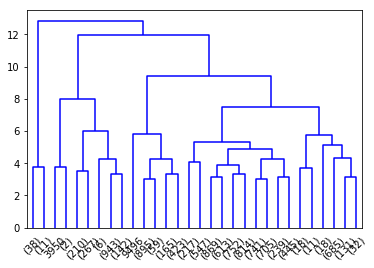

In [33]:
data_dist = pdist(K, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

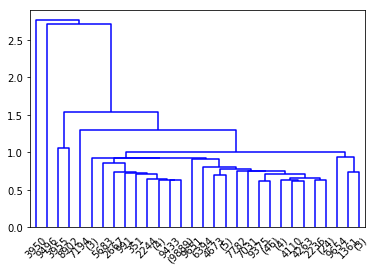

In [34]:
data_dist = pdist(K, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.2, truncate_mode='lastp')

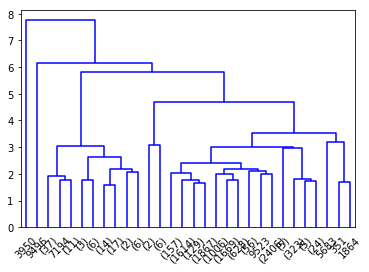

In [35]:
data_dist = pdist(K, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.4, truncate_mode='lastp')

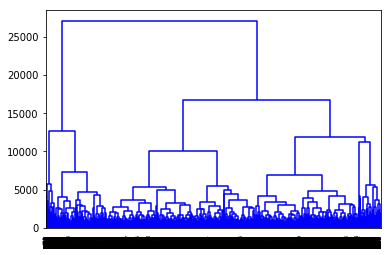

In [49]:
res = dendrogram(data_link, color_threshold=1.0)

In [67]:
# EXPERIMENT kmeans after dbscan ----> worse results

In [81]:
df_new['labels'] = dbscan.labels_

C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
df_new.labels.value_counts()

 0    58353
-1       33
Name: labels, dtype: int64

In [83]:
scan = df_new[df_new['labels'] == 0]

In [84]:
scan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58353 entries, 0 to 58385
Data columns (total 6 columns):
VehicleAge      58353 non-null int64
VehOdo          58353 non-null int64
MMR_factor      58353 non-null float64
VehBCost        58353 non-null float64
WarrantyCost    58353 non-null int64
labels          58353 non-null int64
dtypes: float64(2), int64(4)
memory usage: 3.1 MB


In [85]:
scan.head()

,VehicleAge,VehOdo,MMR_factor,VehBCost,WarrantyCost,labels
0,2,61184,8685.25,6100.0,533,0
1,3,92383,6459.25,4000.0,1630,0
2,2,45965,9635.50,7500.0,693,0
3,4,80169,6217.00,4725.0,1633,0
4,4,77372,6551.25,5670.0,1623,0


In [103]:
ab = scan[['VehicleAge','VehBCost']]

In [104]:
A = MinMaxScaler().fit_transform(ab.values)

In [105]:
kmeans = KMeans(n_clusters = 6, n_init = 7, max_iter = 150)
kmeans.fit(A)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=150,
       n_clusters=6, n_init=7, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [106]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([10030,  8910,  7566, 12663, 14073,  5111], dtype=int64))

In [107]:
hist, bins = np.histogram(kmeans.labels_, 
                          bins=range(0, len(set(kmeans.labels_)) + 1))
dict(zip(bins, hist))

{0: 10030, 1: 8910, 2: 7566, 3: 12663, 4: 14073, 5: 5111}

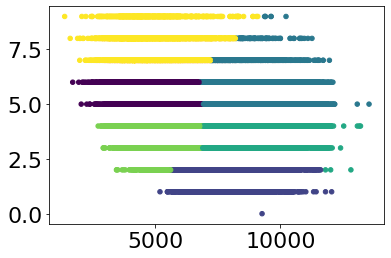

In [109]:
plt.scatter(scan['VehBCost'], scan['VehicleAge'], 
            c=kmeans.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [110]:
# MMR_factor-warrantycost: sse 145 sil 0.35
# MMR_factor-vehicleage: sse 235 sil 0.485  
# vehbcost-vehicleage: sse 107 sil 0.60 BEST VALUES 2 ----- without outliers(fillna=median) sse 667 sil: 0.40 WHY?????
# vehbcost-vehicleage-warranty: sse 407 sil 0.36 BEST VALUES 3 
# vehbcost-vehicleage-vehodo: sse 637 sil 0.32
# vehbcost-vehicleage-vehodo: sse 1770 sil 0.39 ----- 2 clusters
print('SSE %s' % kmeans.inertia_)  #sse 93 sil 0.35 with warranty and vehbcost with outliers: sse 799 sli 0.33
print('Silhouette %s' % silhouette_score(A, kmeans.labels_,sample_size = 10000)) #sse 345 sil 0,26 adding vehodo

SSE 624.4326676589947
Silhouette 0.3877193800079094


In [142]:
A = MinMaxScaler().fit_transform(noise.values)

In [50]:
noise

,VehicleAge,VehOdo,MMR_factor,VehBCost,WarrantyCost,labels
0,2,61184,8685.25,6100.0,533,0
1,3,92383,6459.25,4000.0,1630,0
2,2,45965,9635.50,7500.0,693,0
3,4,80169,6217.00,4725.0,1633,0
4,4,77372,6551.25,5670.0,1623,0
5,2,24541,5175.50,5430.0,462,0
6,5,81478,8808.75,7675.0,723,0
7,1,56717,9929.00,7810.0,920,0
8,4,34616,6912.50,5870.0,462,0
9,3,57337,4815.50,4825.0,505,0


In [99]:
noise

,VehicleAge,VehOdo,MMR_factor,VehBCost,WarrantyCost,labels
0,2,61184,8685.25,6100.0,533,0
1,3,92383,6459.25,4000.0,1630,0
2,2,45965,9635.50,7500.0,693,0
3,4,80169,6217.00,4725.0,1633,0
4,4,77372,6551.25,5670.0,1623,0
5,2,24541,5175.50,5430.0,462,0
6,5,81478,8808.75,7675.0,723,0
7,1,56717,9929.00,7810.0,920,0
8,4,34616,6912.50,5870.0,462,0
9,3,57337,4815.50,4825.0,505,0
